In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_optimizer
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import transforms, datasets, models, utils
from torchsummary import summary
from glob import glob
from PIL import Image
from tqdm.notebook import tqdm

import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 디바이스 자동 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# pretrained inception v3 모듈이 사용한 평균과 표준편차로 Normalize
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((512, 512)),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])])

In [4]:
class ImageDataset(Dataset):
    def __init__(self, folder, class_to_idx, transform=None, label_list=None):
        if label_list:
            n = len(label_list)
            idx_to_class = {v: k for k, v in class_to_idx.items()}
            cls_list = [idx_to_class[label_list[i]] for i in range(n)]
            path_list = []
            for cls in cls_list:
                paths = glob(folder + f'/{cls}/*.jpg')
                for path in paths:
                    path_list.append(path)
            self.fpaths = path_list
        else:
            self.fpaths = glob(folder + '/*/*.jpg')
            
        random.seed(27)
        random.shuffle(self.fpaths)
        self.labels = [class_to_idx[fpath.split('/')[-1].split('_')[2]] for fpath in self.fpaths]
        self.transform = transform

    def __len__(self): 
        return len(self.fpaths)
    def __getitem__(self, idx):
        f = self.fpaths[idx]
        image = Image.open(f)
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

12개 카테고리
- 쌀밥, 잡곡밥, 김치볶음밥, 비빔밥, 짜장면, 크림파스타, 시레기된장국, 떡갈비, 떡볶이, 갈치조림, 치킨, 돈까스

In [5]:
train_dir = './data/img_dataset/train/image'
valid_dir = './data/img_dataset/valid/image'
test_dir = './data/img_dataset/test/image'
class_to_idx = {'01011001': 0,'01012001': 1,'01014001': 2,'01014005': 3,
                '02011027': 4,'02011034': 5,'04012008': 6,'06012004': 7,
                '08014001': 8,'09011002':9,'10012002':10,'10012003':11}
class_names = ('쌀밥', '잡곡밥', '김치볶음밥', '비빔밥', '짜장면', '크림파스타',
               '시래기된장국', '떡갈비', '떡볶이', '갈치조림', '치킨', '돈까스')

In [6]:
train_dataset = ImageDataset(train_dir, class_to_idx, transform)
valid_dataset = ImageDataset(valid_dir, class_to_idx, transform)
test_dataset = ImageDataset(test_dir, class_to_idx, transform)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

데이터 size 확인

In [8]:
for (X_train, y_train) in train_loader:
    print('X_train', X_train.size(), 'type:', X_train.type())
    print('y_train', y_train.size(), 'type:', y_train.type())
    break

X_train torch.Size([16, 3, 512, 512]) type: torch.FloatTensor
y_train torch.Size([16]) type: torch.LongTensor


데이터 출력

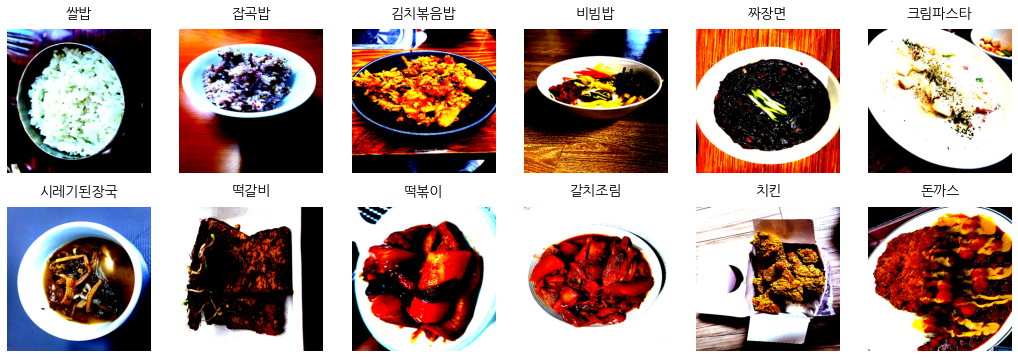

In [9]:
sample_indices = [119, 126, 8, 36, 147, 144, 76, 128, 3, 132, 5, 162]
plt.figure(figsize=(18, 6))
for idx, s_idx in enumerate(sample_indices):
    plt.subplot(2, 6, idx + 1)
    image, label = train_dataset[s_idx]
    plt.title(class_names[label], fontsize=14, pad=12)
    plt.imshow(np.clip(image, 0, 1).permute(2, 1, 0))
    plt.axis('off');

In [10]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    cost = 0
    correct = 0
    
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        cost += loss
        prediction = output.max(1, keepdim=True)[1]
        correct += prediction.eq(label.view_as(prediction)).sum().item()
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.4f}'
                  .format(Epoch, batch_idx * len(image),
                          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                          loss.item()))
        
    cost /= len(train_loader.dataset)
    accuracy = correct / len(train_loader.dataset)
    return cost, accuracy

In [11]:
@torch.no_grad()
def evaluate(model, valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    correct_pred = {class_name: 0 for class_name in class_names}
    total_pred = {class_name: 0 for class_name in class_names}
    
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        valid_loss += criterion(outputs, labels).item()
        predictions = outputs.max(1, keepdim=True)[1]
        correct += predictions.eq(labels.view_as(predictions)).sum().item()
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1
    
    valid_loss /= len(valid_loader.dataset)
    valid_accuracy = correct / len(valid_loader.dataset)
    class_acc_list = [correct_count / total_pred[class_name] 
                          for class_name, correct_count in correct_pred.items()]    
    
    return valid_loss, valid_accuracy, class_acc_list

In [12]:
def get_model(alpha=30):
    model = models.inception_v3(pretrained=True, aux_logits=False)    
    # Layer Freeze 설정
    n = len(list(model.parameters()))
    for i, param in enumerate(model.parameters()):        
        if i < n - alpha:
            param.requires_grad = False
    
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(class_names))
    return model.to(device)

In [13]:
model = get_model()
summary(model, torch.zeros(1,3,512,512));

Layer (type:depth-idx)                   Output Shape              Param #
├─BasicConv2d: 1-1                       [-1, 32, 255, 255]        --
|    └─Conv2d: 2-1                       [-1, 32, 255, 255]        (864)
|    └─BatchNorm2d: 2-2                  [-1, 32, 255, 255]        (64)
├─BasicConv2d: 1-2                       [-1, 32, 253, 253]        --
|    └─Conv2d: 2-3                       [-1, 32, 253, 253]        (9,216)
|    └─BatchNorm2d: 2-4                  [-1, 32, 253, 253]        (64)
├─BasicConv2d: 1-3                       [-1, 64, 253, 253]        --
|    └─Conv2d: 2-5                       [-1, 64, 253, 253]        (18,432)
|    └─BatchNorm2d: 2-6                  [-1, 64, 253, 253]        (128)
├─MaxPool2d: 1-4                         [-1, 64, 126, 126]        --
├─BasicConv2d: 1-5                       [-1, 80, 126, 126]        --
|    └─Conv2d: 2-7                       [-1, 80, 126, 126]        (5,120)
|    └─BatchNorm2d: 2-8                  [-1, 80, 126, 126]

**Augmentation을 위한 transform**
* 회전, 밝기, 명도

기존 Transform에 augmentation에 사용할 transform 추가

In [14]:
# 90도 회전
rotation = transforms.Compose(transform.transforms + [transforms.RandomRotation([90, 90])])
# 0.5로 이미지 밝기 조절
brightness = transforms.Compose(transform.transforms + [transforms.ColorJitter(brightness=[0.5, 0.5])])
# 1.5으로 이미지 명도 조절
saturation = transforms.Compose(transform.transforms + [transforms.ColorJitter(saturation=[1.5, 1.5])])

transform_list = [rotation, brightness, saturation]

전체 클래스에 Augmentation 적용

In [15]:
EPOCHS = 10
model = get_model()
optimizer = torch_optimizer.AdaBound(model.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss()

train_loss_list = []
valid_loss_list = []
train_acc_list = []
valid_acc_list = []

for Epoch in tqdm(range(1, EPOCHS+1), total=EPOCHS):
    label_list = list(class_to_idx.values())
    aug_dataset = ConcatDataset([ImageDataset(train_dir, class_to_idx, aug_transform, label_list) 
                                      for aug_transform in transform_list])
    update_train_dataset = ConcatDataset([train_dataset, aug_dataset])
    update_train_loader = DataLoader(update_train_dataset, batch_size=16, shuffle=True)
    
    cost, accuracy = train(model, update_train_loader, optimizer, log_interval=30)
    valid_loss, valid_accuracy, class_acc_list = evaluate(model, valid_loader)
    train_loss_list.append(cost)
    valid_loss_list.append(valid_loss)
    train_acc_list.append(accuracy)
    valid_acc_list.append(valid_accuracy)
    
    print('\n[EPOCH: {}]\tValid Loss: {:.4f}, Valid Accuracy: {:.2f} %\n'.
          format(Epoch, valid_loss, valid_accuracy * 100))

  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 1 [0/10080(0%)]	Train Loss: 2.5945
Train Epoch: 1 [480/10080(5%)]	Train Loss: 1.3913
Train Epoch: 1 [960/10080(10%)]	Train Loss: 0.4562
Train Epoch: 1 [1440/10080(14%)]	Train Loss: 0.7549
Train Epoch: 1 [1920/10080(19%)]	Train Loss: 0.3695
Train Epoch: 1 [2400/10080(24%)]	Train Loss: 0.4715
Train Epoch: 1 [2880/10080(29%)]	Train Loss: 0.4918
Train Epoch: 1 [3360/10080(33%)]	Train Loss: 0.5735
Train Epoch: 1 [3840/10080(38%)]	Train Loss: 0.5084
Train Epoch: 1 [4320/10080(43%)]	Train Loss: 0.6989
Train Epoch: 1 [4800/10080(48%)]	Train Loss: 0.4190
Train Epoch: 1 [5280/10080(52%)]	Train Loss: 0.2939
Train Epoch: 1 [5760/10080(57%)]	Train Loss: 0.1660
Train Epoch: 1 [6240/10080(62%)]	Train Loss: 0.7311
Train Epoch: 1 [6720/10080(67%)]	Train Loss: 0.3202
Train Epoch: 1 [7200/10080(71%)]	Train Loss: 0.4187
Train Epoch: 1 [7680/10080(76%)]	Train Loss: 0.1791
Train Epoch: 1 [8160/10080(81%)]	Train Loss: 0.4727
Train Epoch: 1 [8640/10080(86%)]	Train Loss: 0.9364
Train Epoch: 1 [912

Train Epoch: 8 [1920/10080(19%)]	Train Loss: 0.0044
Train Epoch: 8 [2400/10080(24%)]	Train Loss: 0.0154
Train Epoch: 8 [2880/10080(29%)]	Train Loss: 0.1206
Train Epoch: 8 [3360/10080(33%)]	Train Loss: 0.0276
Train Epoch: 8 [3840/10080(38%)]	Train Loss: 0.0408
Train Epoch: 8 [4320/10080(43%)]	Train Loss: 0.0058
Train Epoch: 8 [4800/10080(48%)]	Train Loss: 0.0154
Train Epoch: 8 [5280/10080(52%)]	Train Loss: 0.0057
Train Epoch: 8 [5760/10080(57%)]	Train Loss: 0.0029
Train Epoch: 8 [6240/10080(62%)]	Train Loss: 0.0021
Train Epoch: 8 [6720/10080(67%)]	Train Loss: 0.0511
Train Epoch: 8 [7200/10080(71%)]	Train Loss: 0.1885
Train Epoch: 8 [7680/10080(76%)]	Train Loss: 0.0086
Train Epoch: 8 [8160/10080(81%)]	Train Loss: 0.0134
Train Epoch: 8 [8640/10080(86%)]	Train Loss: 0.0055
Train Epoch: 8 [9120/10080(90%)]	Train Loss: 0.0074
Train Epoch: 8 [9600/10080(95%)]	Train Loss: 0.0695

[EPOCH: 8]	Valid Loss: 0.0164, Valid Accuracy: 93.19 %

Train Epoch: 9 [0/10080(0%)]	Train Loss: 0.1836
Train Epoch

일부 클래스에만 Augmentation 적용

In [24]:
EPOCHS = 10
model = get_model()
optimizer = torch_optimizer.AdaBound(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

train_loss_list = []
valid_loss_list = []
train_acc_list = [] 
valid_acc_list = []

for Epoch in tqdm(range(1, EPOCHS+1), total=EPOCHS):
    if Epoch == 1:
        cost, accuracy = train(model, train_loader, optimizer, log_interval=30)
        valid_loss, valid_accuracy, class_acc_list = evaluate(model, valid_loader) 
        train_loss_list.append(cost)
        valid_loss_list.append(valid_loss)
        train_acc_list.append(accuracy)
        valid_acc_list.append(valid_accuracy)

        print('\n[EPOCH: {}]\tValid Loss: {:.4f}, Valid Accuracy: {:.2f} %\n'.
              format(Epoch, valid_loss, valid_accuracy * 100))
        # 정확도가 낮은 3개의 클래스 리스트에 추가
        label_list = sorted(range(len(class_acc_list)), key=lambda x: class_acc_list[x])[:3]
    else:
        # 정확도가 낮은 3개의 클래스만 augmentation
        aug_dataset = ConcatDataset([ImageDataset(train_dir, class_to_idx, aug_transform, label_list) 
                                      for aug_transform in transform_list])
        update_train_dataset = ConcatDataset([train_dataset, aug_dataset])
        update_train_loader = DataLoader(update_train_dataset, batch_size=16, shuffle=True)
        
        cost, accuracy = train(model, update_train_loader, optimizer, log_interval=30)
        valid_loss, valid_accuracy, class_acc_list = evaluate(model, valid_loader)
        train_loss_list.append(cost)
        valid_loss_list.append(valid_loss)
        train_acc_list.append(accuracy)
        valid_acc_list.append(valid_accuracy)
        
        print('\n[EPOCH: {}]\tValid Loss: {:.4f}, Valid Accuracy: {:.2f} %\n'.
              format(Epoch, valid_loss, valid_accuracy * 100))        
        label_list = sorted(range(len(class_acc_list)), key=lambda x: class_acc_list[x])[:3]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 1 [0/2520(0%)]	Train Loss: 2.5165
Train Epoch: 1 [480/2520(19%)]	Train Loss: 0.7813
Train Epoch: 1 [960/2520(38%)]	Train Loss: 0.6071
Train Epoch: 1 [1440/2520(57%)]	Train Loss: 0.8110
Train Epoch: 1 [1920/2520(76%)]	Train Loss: 0.4151
Train Epoch: 1 [2400/2520(95%)]	Train Loss: 0.2642

[EPOCH: 1]	Valid Loss: 0.0209, Valid Accuracy: 90.28 %

Train Epoch: 2 [0/4410(0%)]	Train Loss: 0.4361
Train Epoch: 2 [480/4410(11%)]	Train Loss: 0.6663
Train Epoch: 2 [960/4410(22%)]	Train Loss: 0.6372
Train Epoch: 2 [1440/4410(33%)]	Train Loss: 0.2472
Train Epoch: 2 [1920/4410(43%)]	Train Loss: 0.2667
Train Epoch: 2 [2400/4410(54%)]	Train Loss: 0.6200
Train Epoch: 2 [2880/4410(65%)]	Train Loss: 0.2308
Train Epoch: 2 [3360/4410(76%)]	Train Loss: 0.0950
Train Epoch: 2 [3840/4410(87%)]	Train Loss: 0.3325
Train Epoch: 2 [4320/4410(98%)]	Train Loss: 0.6702

[EPOCH: 2]	Valid Loss: 0.0145, Valid Accuracy: 93.06 %

Train Epoch: 3 [0/4410(0%)]	Train Loss: 1.1708
Train Epoch: 3 [480/4410(11%)]	Trai

In [30]:
#torch.save(model.state_dict(), './model/classifier.pt')

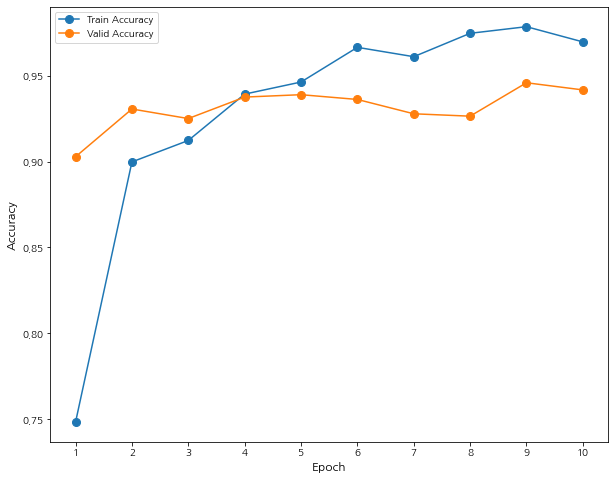

In [36]:
plt.figure(figsize=(10, 8))
plt.plot(range(1, EPOCHS + 1), train_acc_list, color='tab:blue', 
         marker='o', markersize=8, label='Train Accuracy')
plt.plot(range(1, EPOCHS + 1), valid_acc_list, color='tab:orange',
         marker='o', markersize=8, label='Valid Accuracy')
plt.xticks(range(1, EPOCHS + 1))
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend();

In [37]:
test_loss, test_accuracy, _ = evaluate(model, test_loader)

In [44]:
print(f'test_loss: {test_loss:.4f}, test_accuracy: {test_accuracy:.4f}')

test_loss: 0.0197, test_accuracy: 0.9222
